In [2]:
import os
import sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
SRC = os.path.abspath(os.path.join(ROOT, "src"))
sys.path.append(ROOT)
sys.path.append(SRC)

In [3]:
import dvc.api
import pandas as pd
from src.etl.transform import change_columns_types
from src.etl.extract import extract_data
params = dvc.api.params_show()
types_columns: list[str] = params['preparation']['types']['columns']


file_prepared_data =os.path.join(ROOT, params['paths']['prepared_data'])
df = extract_data(file_prepared_data)
df = change_columns_types(df, types_columns)

In [4]:
types_columns

{'InvoiceNo': 'str',
 'StockCode': 'str',
 'Description': 'str',
 'Quantity': 'int',
 'InvoiceDate': 'datetime',
 'UnitPrice': 'float',
 'CustomerID': 'int',
 'Country': 'str'}

In [69]:
customers = df['CustomerID'].unique()
df['InvoiceDate']
min_date = df['InvoiceDate'].min()
max_date = df['InvoiceDate'].max()

current_date = max_date + pd.DateOffset(days=1)

customer_id_list = []
recency_list = []
frecuency_list = []
monetary_list = []
is_churn_list = []

for customer in customers:
    customer_activity = df[ df['CustomerID'] == customer] 
    last_shopping_day = customer_activity['InvoiceDate'].max()
    last_shopping_day_minus_one_year = last_shopping_day - pd.DateOffset(years=1)
    shopping_activity_last_year = customer_activity[ customer_activity['InvoiceDate'] > last_shopping_day_minus_one_year] 

    # If custumer has more than 1 invoice number
    is_churn = customer_activity['InvoiceNo'].unique().size > 1
    # the number of days of the last purchse
    recency = (current_date - last_shopping_day).days
    # Mean of unique invoicr id in the last year
    frecuency = shopping_activity_last_year['InvoiceNo'].unique().size / 12
    # mean cost total of each invoice in the last year
    monetary = (shopping_activity_last_year['Quantity'] * shopping_activity_last_year['UnitPrice']).mean()

    customer_id_list.append(customer)
    recency_list.append(recency)
    frecuency_list.append(frecuency)
    monetary_list.append(monetary)
    is_churn_list.append(is_churn)

In [75]:
colums = params['featurization']['columns']
process_data = list(zip(customer_id_list,recency_list,frecuency_list,monetary_list,is_churn_list))
process_df = pd.DataFrame(process_data, columns=colums)

In [81]:
process_df

,customer_id,recency,frequency,monetary,is_churn
0,17850.0,372,2.833333,18.152222,True
1,13047.0,32,0.833333,18.822907,True
2,12583.0,3,1.166667,28.306256,True
3,13748.0,96,0.416667,33.866071,True
4,15100.0,334,0.250000,292.000000,True
...,...,...,...,...,...
4334,13436.0,2,0.083333,16.407500,False
4335,15520.0,2,0.083333,19.083333,False
4336,13298.0,1,0.083333,180.000000,False
4337,14569.0,1,0.083333,18.949167,False


# Data analysis of the first process data


In [6]:
file_prepared_data =os.path.join(ROOT, params['paths']['featurization_data'])
df = extract_data(file_prepared_data)

In [7]:
total_rows = len(df) 
df.groupby('is_churn').size() / total_rows

is_churn
False    0.655681
True     0.344319
dtype: float64

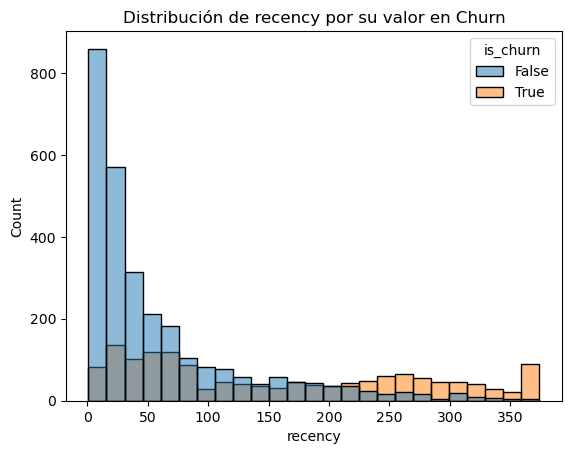

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='recency', hue='is_churn')
plt.title('Distribución de recency por su valor en Churn')
plt.show()


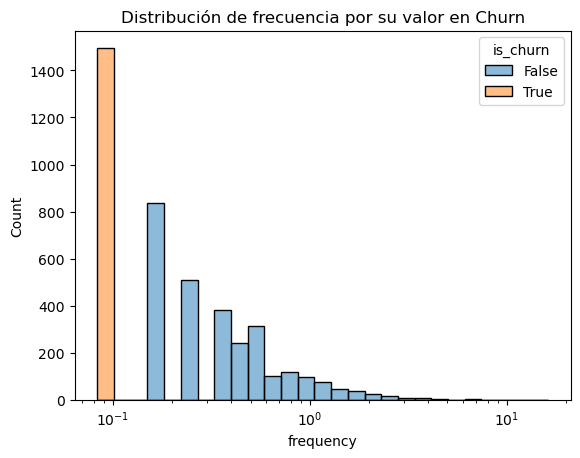

In [9]:
sns.histplot(data=df, x='frequency', hue='is_churn', log_scale=(True, False))
plt.title('Distribución de frecuencia por su valor en Churn')
plt.show()

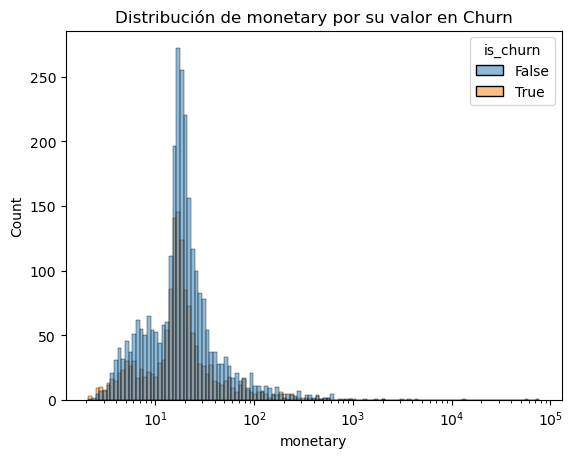

In [10]:
sns.histplot(data=df, x='monetary', hue='is_churn', log_scale=(True, False))
plt.title('Distribución de monetary por su valor en Churn')
plt.show()

In [11]:
### Algunas transformaciones extras
import numpy as np
df_logged = df.copy()
df_logged['frequency'] = np.log(df_logged['frequency'])



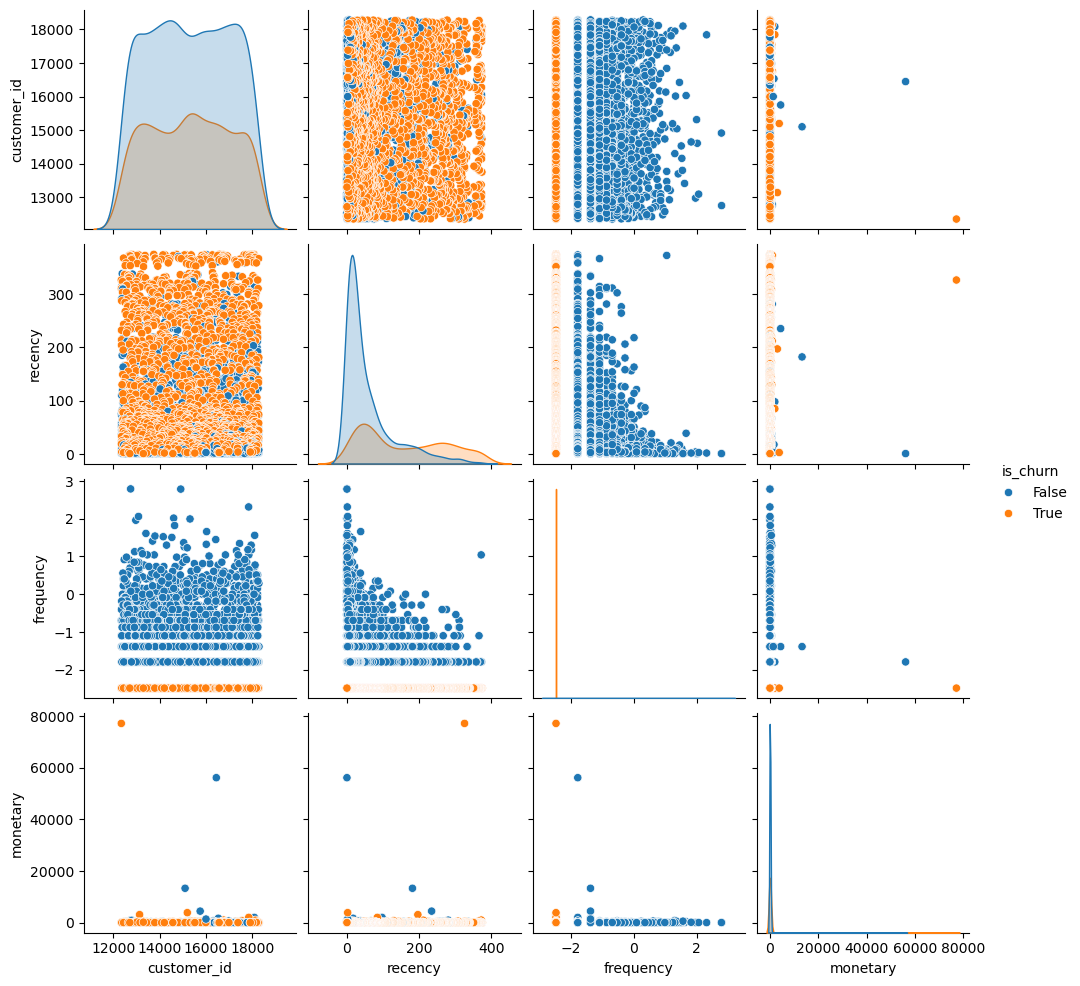

In [21]:
sns.pairplot(df_logged, hue='is_churn') 
plt.show()

In [ ]:
## Ajustar datos desbalanceados usando SMOTE

